#Classificação de Textos

Vamos utilizar o conjunto de dados da IMDB (https://ai.stanford.edu/~amaas/data/sentiment/), que contém *reviews* (textos) de 50 mil filmes. Todas as *reviews* são rotuladas como "Positiva" ou "Negativa".

Vamos utilzar uma rede neural profunda para realizar a classificação desses textos.

Esta aula está dividida em:

- *Download* do conjunto de dados IMDB
- Carregar um modelo BERT pré-treinado
- Construir um modelo ao combinar o BERT com um classificador
- Fine-tuning do BERT
- Salvar o modelo

In [1]:
!pip install -U "tensorflow-text==2.13.*" # executar na 1a vez
!pip install "tf-models-official==2.13.*" # executar na 1a vez
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 13.6 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=796a92ecba16fd5a0f78b7e73c5928939f255638e755190db93d2286229f69c1
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


## *Download* do conjunto de dados IMDB

Realizando o *download* e descompactando o conjunto de dados.


In [2]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

84125825/84125825 [==============================] - 1s 0us/step


Usaremos `text_dataset_from_directory` para criar um rotulado `tf.data.Dataset`.

O conjunto de dados do IMDB já foi dividido em treino e teste, mas falta um conjunto de validação. Vamos criar um conjunto de validação usando uma divisão 80:20 dos dados de treinamento usando o argumento `validation_split`.

Nota: Ao usar os argumentos `validation_split` e `subset`, certifique-se de especificar uma semente aleatória (*seed*) ou passar `shuffle=False`, para que as divisões de validação e treinamento não tenham sobreposição.

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


Vamos dar uma olhada em algumas *reviews*.

In [4]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

##Transformers e BERT

In [5]:
#Escolher um modelo BERT pré-treinado (TensorFlow Hub)

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
#bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'modelo BERT selecionado           : {tfhub_handle_encoder}')
print(f'Modelo de pré-processamento auto-selecionado: {tfhub_handle_preprocess}')

modelo BERT selecionado           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Modelo de pré-processamento auto-selecionado: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## O modelo de pré-processamento

As entradas de texto precisam ser transformadas em IDs de *token* numérico e organizadas em vários tensores antes de serem inseridas no BERT. O TensorFlow Hub fornece um modelo de pré-processamento correspondente para cada um dos modelos BERT discutidos acima, que implementa essa transformação usando operações de TF da biblioteca TF.text. Não é necessário executar código Python puro fora do modelo do TensorFlow para pré-processar o texto.

O modelo de pré-processamento deve ser aquele referenciado pela documentação do modelo BERT. Para modelos BERT disponibilizados neste *notebook*, o modelo de pré-processamento é selecionado automaticamente.

Observação: você carregará o modelo de pré-processamento em um [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) para compor seu modelo ajustado. Esta é a API preferida para carregar um SavedModel estilo TF2 do TF Hub para um modelo Keras.

In [6]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Vamos testar o modelo de pré-processamento em alguns textos e ver a saída.

In [7]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Agora temos as 3 saídas do pré-processamento que um modelo BERT usaria (`input_words_id`, `input_mask` e `input_type_ids`).

Outros pontos importantes:
- A entrada é truncada para 128 *tokens*.
- O `input_type_ids` tem apenas um valor (0) porque esta é uma única entrada de frase. Para uma entrada de sentença múltipla, teria um número para cada entrada.

Como esse pré-processador de texto é um modelo do TensorFlow, ele pode ser incluído diretamente no seu modelo.

## Utilizando o modelo BERT

Antes de inserir o BERT no nosso modelo, vamos dar uma olhada em suas saídas. Vamos carregá-lo do TF Hub e ver os valores retornados.

In [8]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [9]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.9928099  -0.18611872  0.36673853  0.1523371   0.65504426
  0.9681154  -0.94862705  0.00216182 -0.9877732   0.06842728 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946307  0.34321266  0.33231518 ...  0.21300897  0.71020764
  -0.05771176]
 [-0.2874206   0.3198098  -0.23018597 ...  0.5845501  -0.21329726
   0.72692066]
 [-0.6615712   0.68876785 -0.8743292  ...  0.10877268 -0.2617322
   0.4785534 ]
 ...
 [-0.22561154 -0.28925663 -0.07064398 ...  0.47566003  0.8327717
   0.40025344]
 [-0.29824272 -0.27473173 -0.05450511 ...  0.48849759  1.0955356
   0.18163322]
 [-0.44378266  0.00930682  0.07223728 ...  0.17290092  1.1833241
   0.07898061]]


Os modelos BERT retornam um mapa com 3 chaves importantes: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` representa cada sequência de entrada como um todo. Suas dimensões são `[batch_size, H]`. Podemos considerar isso como um *embedding* para a *review* inteira do filme.
- `sequence_output` representa cada *token* de entrada no contexto. As dimensões são `[batch_size, seq_length, H]`. Podemos consider isso como *embedding* contextual para cada *token* do *review* do filme.
- `encoder_outputs` são as ativações intermediárias dos blocos do Transformer `L`. `outputs["encoder_outputs"][i]` é um Tensor com dimensões `[batch_size, seq_length, 1024]` com as saídas do i-ésimo bloco Transformer, para `0 <= i < L`. O último valor da lista é igual a `sequence_output`.

Para o *fine-tuning* (ajuste fino), usaremos o array `pooled_output`.

## Definindo o modelo

Vamos criar um modelo ajustado muito simples, com o modelo de pré-processamento, o modelo BERT selecionado, uma camada densa e uma camada de Dropout.

In [10]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Vamos dar uma olhada no modelo.

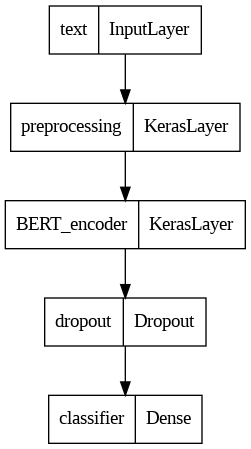

In [11]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

## Treinando o modelo

Agora, temos todas as peças para treinar um modelo, incluindo o módulo de pré-processamento, codificador BERT, dados e classificador.

### Função de perda (*Loss function*)

Como este é um problema de classificação binária e o modelo gera uma probabilidade (uma camada de unidade única), podemos usar a função de perda `losses.BinaryCrossentropy`.


In [12]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Otimizador

Para o *fine-tuning*, vamos usar o mesmo otimizador com o qual o BERT foi originalmente treinado: o "Adaptive Moments" (Adam).

Para a taxa de aprendizado (`init_lr`), você usará o mesmo cronograma do pré-treinamento do BERT: decaimento linear da taxa de aprendizado inicial, prefixada com uma fase de aquecimento linear nos primeiros 10% das etapas de treinamento (`num_warmup_steps `). De acordo com o artigo do BERT, a taxa de aprendizado inicial é menor para o ajuste fino (melhor de 5e-5, 3e-5, 2e-5).

In [13]:
epochs = 5 # treinar pelo menos 5 épocas, mas demora
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Carregando e treinando o modelo BERT

Usando o `classifier_model` criado anteriormente, podemos compilar o modelo com o *loss* (perda), métrica e otimizador escolhidos.

In [14]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Aplicando o modelo antes do treinamento (*fine-tunning*)

In [15]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 97s 123ms/step - loss: 0.7286 - binary_accuracy: 0.5239
Loss: 0.7286415100097656
Accuracy: 0.5238800048828125


O tempo de treinamento varia de acordo com a complexidade do modelo BERT selecionado.

In [16]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
625/625 [==============================] - 176s 271ms/step - loss: 0.4784 - binary_accuracy: 0.7483 - val_loss: 0.3665 - val_binary_accuracy: 0.8384
Epoch 2/5
625/625 [==============================] - 168s 269ms/step - loss: 0.3271 - binary_accuracy: 0.8544 - val_loss: 0.3629 - val_binary_accuracy: 0.8450
Epoch 3/5
625/625 [==============================] - 168s 269ms/step - loss: 0.2497 - binary_accuracy: 0.8942 - val_loss: 0.3806 - val_binary_accuracy: 0.8522
Epoch 4/5
625/625 [==============================] - 168s 268ms/step - loss: 0.1935 - binary_accuracy: 0.9234 - val_loss: 0.4443 - val_binary_accuracy: 0.8502
Epoch 5/5
625/625 [==============================] - 169s 270ms/step - loss: 0.1518 - binary_accuracy: 0.9419 - val_loss: 0.4861 - val_binary_accuracy: 0.8502


## Avaliando o modelo

Vamos ver como o modelo se comporta para classificar textos (reviews) não utilizadas no treinamento.

Dois valores serão retornados. *Loss* (quanto menor, melhor) e acurácia (quanto maior, melhor).

In [17]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

782/782 [==============================] - 96s 123ms/step - loss: 0.4621 - binary_accuracy: 0.8563
Loss: 0.46211370825767517
Accuracy: 0.8563200235366821


### Visualizando Acurácia e Loss ao longo do treinamento

Baseado no objeto `History` retornado por `model.fit()`, podemos visualizar os valores de *loss* e acurácia de treinamento e validação.

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


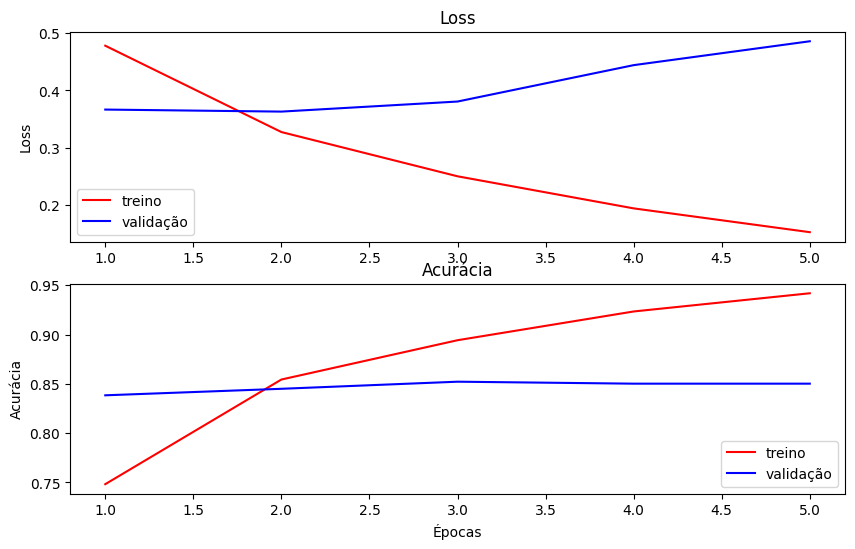

In [18]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='treino')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='validação')
plt.title('Loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='treino')
plt.plot(epochs, val_acc, 'b', label='validação')
plt.title('Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend(loc='lower right')

## Salvando o modelo ajustado


In [19]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))
classifier_model.save(saved_model_path, include_optimizer=False)

Podemos recarregar o modelo salvo e comparar os resultados com os que ainda estão na memória.

In [20]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [21]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Resultados do modelo salvo:')
print_my_examples(examples, reloaded_results)
print('Resultados do modelo na memória:')
print_my_examples(examples, original_results)

Resultados do modelo salvo:
input: this is such an amazing movie! : score: 0.999387
input: The movie was great!           : score: 0.996771
input: The movie was meh.             : score: 0.987483
input: The movie was okish.           : score: 0.055826
input: The movie was terrible...      : score: 0.000889

Resultados do modelo na memória:
input: this is such an amazing movie! : score: 0.999387
input: The movie was great!           : score: 0.996771
input: The movie was meh.             : score: 0.987483
input: The movie was okish.           : score: 0.055826
input: The movie was terrible...      : score: 0.000889

